## Hecho por: David Ramírez Betancourth
## C.C. 1002636667
## Ingeniería Electrónica
## Universidad Nacional de Colombia Sede Manizales

In [1]:
import matplotlib.pyplot as plt #Graficador
import numpy as np #Opearciones entre arrays
import scipy.signal as sig #métodos de señales (welch)
import scipy.stats as stats
import time
import timeit


import tensorflow as tf # Red Neuronal
from sklearn.model_selection import train_test_split #Divisor de datos de entrenamiento y testeo
from sklearn.preprocessing import MinMaxScaler #Normalizador de escala
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential #Red Neuronal
from tensorflow.keras.layers import Dense, Dropout, LSTM #Conexión neuronas
from tensorflow.keras.optimizers import Adam #Optimizador de red

#Generar Señal

$f_o = 1 Hz$

$x(t) = cos(\omega_o) - \frac{sin(3\omega_o)}{3} + \frac{cos(5\omega_o)}{5}$

$\xi(t) = x(t) + \eta(t)$

Aplicar método welch: Consiste en hallar la FFT por ventaneos de la señal y luego promediando las PSD de cada segmento

In [2]:

np.random.seed(0)

def randomvector(sigma, N):
    """Genera un vector gaussiano eta = N(0, sigma)"""
    return np.random.normal(0, np.sqrt(sigma), size=N)

def real_signal(t, wo):
    """x(t)"""
    return np.cos(wo*t) - (1/3)*np.sin(3*wo*t) + (1/5)*np.cos(5*wo*t)

def welch_vector(X, fs, nperseg, window, nfft):
    """Generar psd de la señal xi
       ventaneo hamming
       overlap del 50% de la vetana
    """
    return sig.welch(X, fs, window=window, nperseg=nperseg, noverlap=(nperseg//2), nfft=nfft)

def matrix_data(t, wo, sigma, N, M):
    N = len(t)
    X = np.zeros((M, N))  # Ajustar la dimensión de la matriz
    for i in range(M):
        X_true = real_signal(t, wo)  # Generar señal real
        X[i] = X_true + randomvector(sigma, N)  # Combinarla con ruido, meterla a la fila
    return X

def matrix_psd(X, fs, nperseg, window, nfft, fn, N, M):

    Psd_real = np.zeros((M, N))  # Matriz para almacenar los PSD
    for i in range(M):
        f, psd = welch_vector(X[i], fs, nperseg, window, nfft)
        Psd_real[i] = psd
    
    return f[:fn], Psd_real[:, :fn]


def matrix_psd_mean(X, fs, nperseg, window, nfft, fn, N, M):

    f, psd_m = matrix_psd(X, fs, nperseg, window, nfft, fn, N, M)
    
    Psd_mean = np.mean(psd_m, axis=0)
    Psd_mean_m =np.zeros((M, fn))
    for i in range(M):
        Psd_mean_m[i] = Psd_mean

    return f, Psd_mean_m




# Definir tipo de Red

## Red #1 (MLP)

Modelo tipo Sequential(MLP): Las capas se apilan una tras otra, lo que hace que el flujo de datos sea simple y directo. Es MLP porque contiene perceptrones. Capa de entrada - capa oculta - capa de salida. Configuración Dense.

Optimizador Adam: Utiliza AdaGrad y RMSProp. Consiste en:
- Calcular Gradiente
- Se corrige sesgos
- Se actualizan pesos
- Red #2 = LSTM

# Preparar Datos

Scaler: normaliza los datos a una escala deseada (0,1)

train test split: Divide los datos un porcentaje deseado 70/30, 70 entrenar, 30 test.

In [3]:
def data_split_scaled(X , Psd, test_size):
    scalerX = MinMaxScaler(feature_range=(0, 1))
    scalerPsd = MinMaxScaler(feature_range=(0, 1))

    X_scaled = scalerX.fit_transform(X)
    Psd_scaled = scalerPsd.fit_transform(Psd)

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, Psd_scaled, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test, X_scaled, Psd_scaled, scalerX, scalerPsd


def NN_define(type, X_train, y_train, epochs, N, fn):
    input_shape = N
    output_shape = fn

    if type == 1:
        model = Sequential([
            tf.keras.Input(shape=(input_shape,)), #Capa de entrada
            Dense(input_shape//2, activation='relu'), #Capa oculta
            Dropout(0.5), #Dropout para no sobreajuste
            Dense(input_shape//4, activation='relu'), # Capa oculta
            Dense(128, activation='relu'), #Capa oculta
            Dense(output_shape) #Capa de salida
        ])
        
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])

    else:
        model = Sequential()

        model.add(LSTM(units=25, return_sequences=True, input_shape=(X_train.shape[1], 1)))
        model.add(LSTM(units=25, return_sequences=False))
        model.add(Dense(units=y_train.shape[1]))

        model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['accuracy'])

    return model.fit(X_train, y_train, epochs=epochs, validation_split=0.2), model




In [4]:
# Parámetros
N = 1024  # Longitud señal
M = 1000  # Número de señales
fo = 10  # 10Hz frecuencia
wo = 2*np.pi*fo
sigma = 0.1  # Varianza
t = np.linspace(0, 1, N)  # Vector de tiempo de 0 a 3 segundos
fs = 1/(t[1]-t[0])  # Frecuencia de muestreo
nperseg = N - 1
nfft = N*2 - 1
fn = int(5*fo) + 100

# Generación de datos
X = matrix_data(t, wo, sigma, N, M)

# Cálculo de PSD para cada señal
f, Psd_real = matrix_psd(X, fs, nperseg, 'blackmanharris', nfft, fn, N, M)
f, Psd_mean = matrix_psd_mean(X, fs, nperseg, 'blackmanharris', nfft, fn, N, M)


X_train, X_test, y_train, y_test, X_scaled, Psd_scaled, scalerX, scalerPsd= data_split_scaled(X, Psd_real, 0.3)
X_train_mean, X_test_mean, y_train_mean, y_test_mean, X_scaled_mean, Psd_scaled_mean, scalerX_mean, scalerPsd_mean= data_split_scaled(X, Psd_mean, 0.3) 

X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

history1, model1 = NN_define(1, X_train, y_train, 10, N, fn)
history2, model2 = NN_define(1, X_train_mean, y_train_mean, 10, N, fn)
history3, model3 = NN_define(2, X_train_reshaped, y_train, 10, N, fn)


Epoch 1/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 3.8752e-04 - loss: 0.1331 - val_accuracy: 0.0071 - val_loss: 0.0563
Epoch 2/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0069 - loss: 0.0613 - val_accuracy: 0.0071 - val_loss: 0.0480
Epoch 3/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0056 - loss: 0.0514 - val_accuracy: 0.0071 - val_loss: 0.0406
Epoch 4/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0041 - loss: 0.0428 - val_accuracy: 0.0071 - val_loss: 0.0339
Epoch 5/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0044 - loss: 0.0372 - val_accuracy: 0.0214 - val_loss: 0.0291
Epoch 6/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0176 - loss: 0.0327 - val_accuracy: 0.0429 - val_loss: 0.0258
Epoch 7/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0402 - loss: 0.0296 - val_accuracy: 0.0500 - val_loss: 0.0240
Epoch 8/30
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0361 - loss: 0.0274 - val_accuracy: 0.0571

# Rendimiento del Modelo

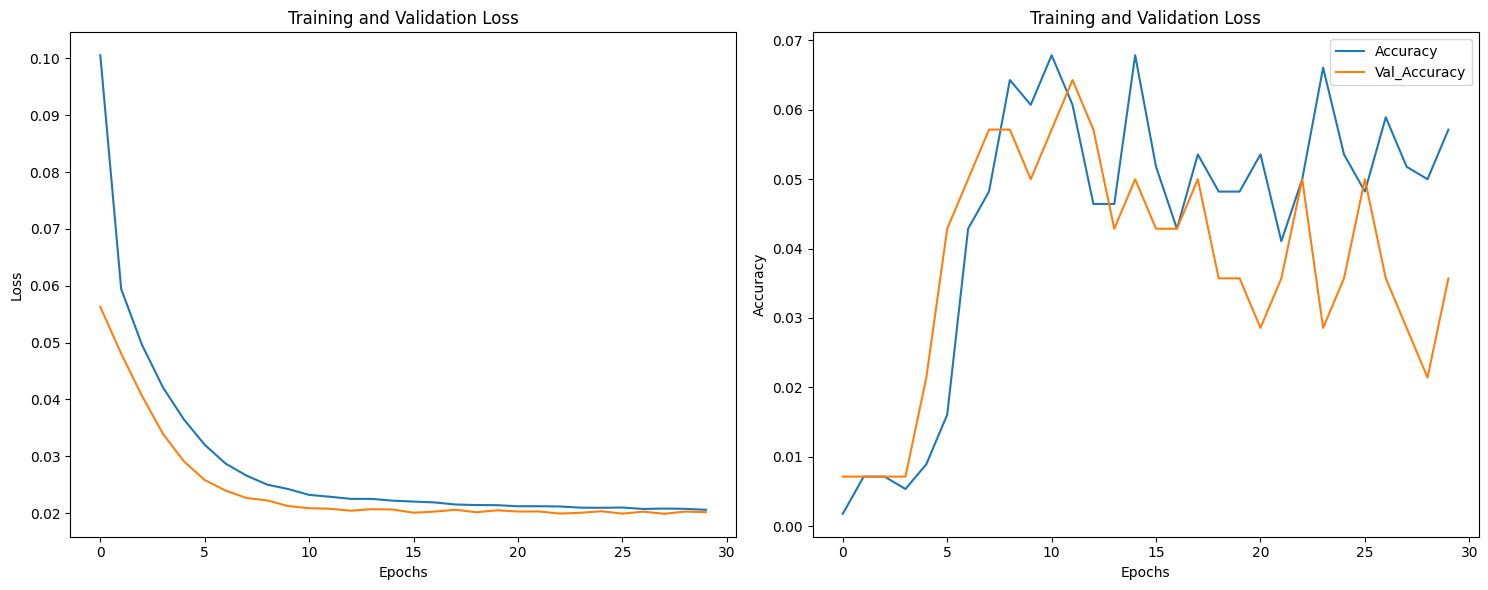

In [5]:

fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(15, 6)
axs[0].plot(history1.history['loss'], label='Training Loss')
axs[0].plot(history1.history['val_loss'], label='Validation Loss')
axs[0].set_title('Training and Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[1].plot(history1.history['accuracy'], label='Accuracy')
axs[1].plot(history1.history['val_accuracy'], label='Val_Accuracy')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Predecir

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
(1000, 150)


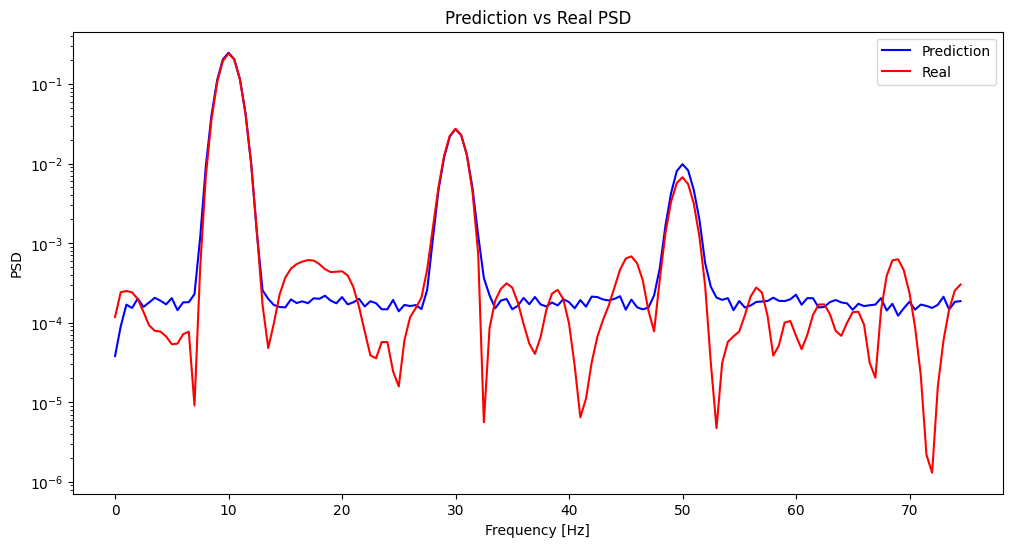

In [6]:
psd_pred_scaled = model1.predict(X_scaled)
psd_pred = scalerPsd.inverse_transform(psd_pred_scaled)
print(psd_pred.shape)
plt.figure(figsize=(12, 6))
plt.semilogy(f, psd_pred[50], color='b', label='Prediction')
plt.semilogy(f, Psd_real[50], color='r', label='Real')
plt.xlabel('Frequency [Hz]')
plt.ylabel('PSD')
plt.title('Prediction vs Real PSD')
plt.legend()
plt.show()

# Reconstruir Señal mediante ifft

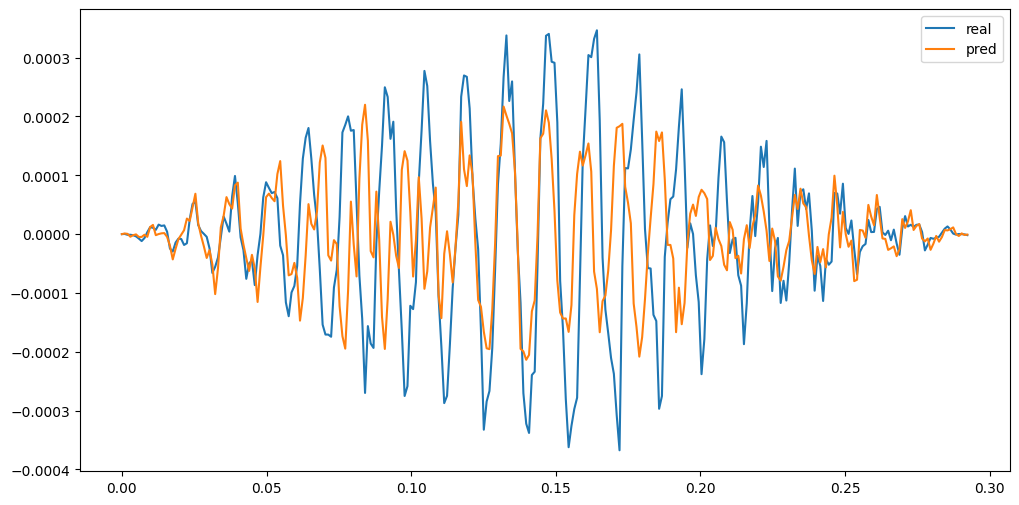

In [7]:
np.random.seed(0)

def reconstruir_senal(f, psd, t):

    # Convertir la PSD en la magnitud del espectro de frecuencia
    magnitud = np.sqrt(psd)

    # Crear un espectro complejo con magnitud y fase aleatoria
    
    fase_aleatoria = np.exp(1j * np.random.uniform(0, 2 * np.pi, len(f)))
    espectro = magnitud * fase_aleatoria

    # Duplicar el espectro para considerar las frecuencias negativas
    espectro_completo = np.concatenate([espectro, np.conj(espectro[::-1])])

    # Realizar la IFFT para obtener la señaligena en el dominio temporal
    senal = np.fft.ifft(espectro_completo)

    # Asegurar que la señaligena resultante sea real
    senal_real = np.real(senal)

    # Shift the reconstructed signal to avoid loss in the middle
    senal_real = np.roll(senal_real, len(senal_real) // 2)

    return senal_real[:len(t)]


rec_X_real = np.zeros((M,300))
rec_X_pred = np.zeros((M,300))

for i in range(psd_pred.shape[0]):
    rec_pred = reconstruir_senal(f, psd_pred[i], t)
    rec_real = reconstruir_senal(f, Psd_real[i], t)
    rec_X_real[i] = rec_real
    rec_X_pred[i] = rec_pred

t_rec = t[:300]

rec_X_real = np.mean(rec_X_real, axis=0)
rec_X_pred = np.mean(rec_X_pred, axis=0)

plt.figure(figsize=(12,6))
plt.plot(t_rec, rec_X_real, label='real')
plt.plot(t_rec, rec_X_pred, label='pred')
plt.legend()
plt.show()

# KDE Kernel density estimation y Umbral Adaptativo

- Hallar el histograma de cada uno de los harmónicos.
- Hacerle KDE para una función limpia gaussiana

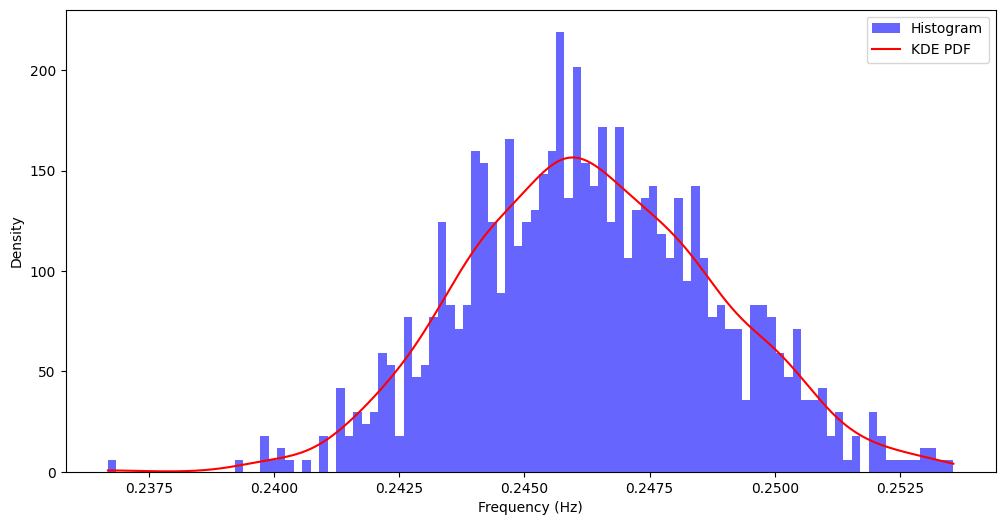

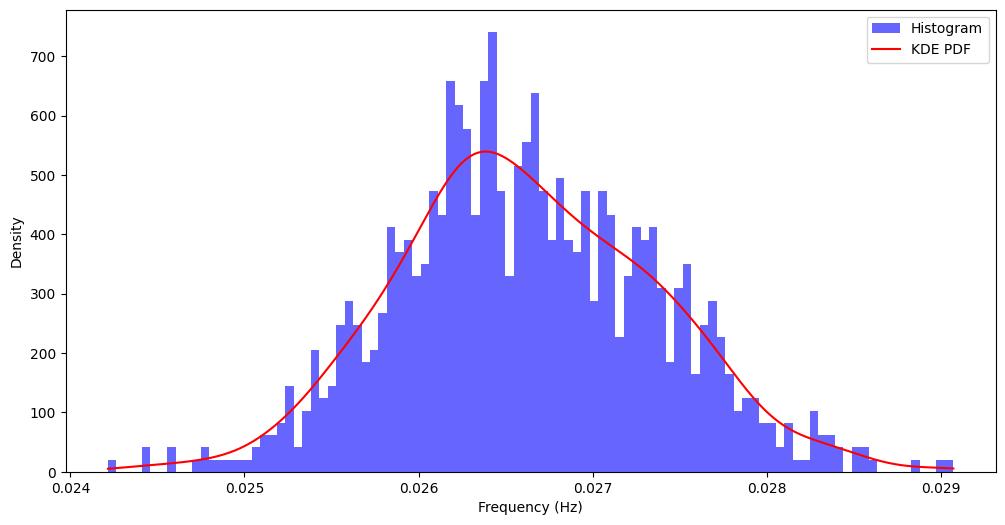

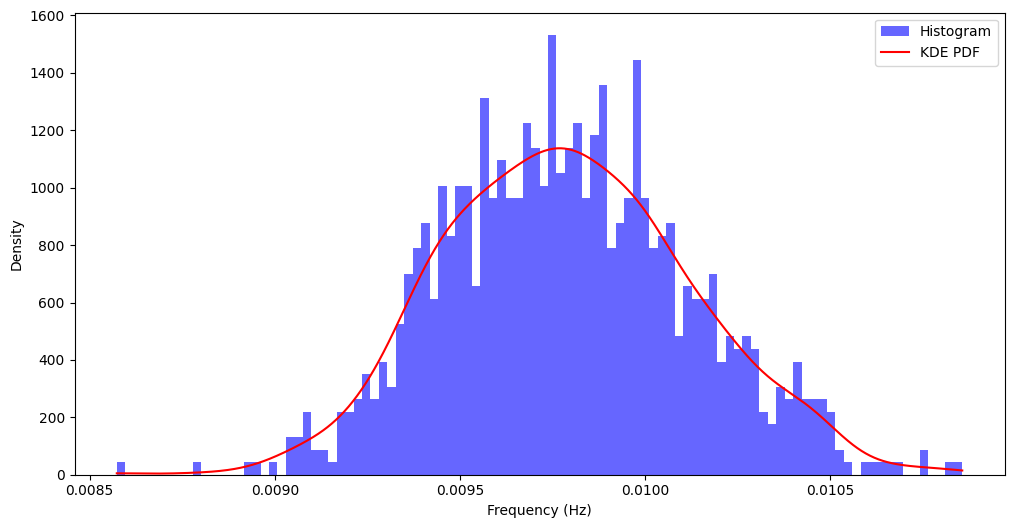

In [8]:
def find_third_peak(f, psd):
    peaks, _ = sig.find_peaks(psd,distance=1)
    harm_f = f[peaks]
    harm_psd = psd[peaks]

    # Obtener el tercer pico más alto en la PSD y su frecuencia correspondiente
    third_harm_index = np.argsort(harm_psd)[-3]  # Índice del tercer mayor pico
    third_harm = harm_psd[third_harm_index]      # Valor del tercer mayor pico
    third_harm_f = harm_f[third_harm_index]      # Frecuencia del tercer mayor pico

    return third_harm, third_harm_f

def thresholding_third_peak(f, psd):
    M = psd.shape[0]
    third_harm_v = np.zeros(M)
    for i in range(M):
        third_har, third_harm_f = find_third_peak(f, psd[i])
        third_harm_v[i] = third_har

    return np.mean(third_harm_v)/2


def thres_filter_vector(f, psd, thresholding):
    peaks, _ = sig.find_peaks(psd,distance=1)
    peaks_filtered = peaks[psd[peaks] > thresholding] #filtrar picos
    harm_psd = psd[peaks_filtered]
    harm_f = f[peaks_filtered]


    return harm_f, harm_psd

# Retorna efectividad del umbral.
def thres_efectivity(f, psd_pred):
    M = psd_pred.shape[0]
    thresholding = thresholding_third_peak(f, psd_pred)
    true_peaks = 0
    for i in range(M):
        _, harm_psd = thres_filter_vector(f, psd_pred[i], thresholding)
        peaks = len(harm_psd)
        if peaks == 3:
            true_peaks += 1
    return true_peaks/M



def kde_harmonics(n_harm, f, Psd_m):
    M = Psd_m.shape[0]
    harmonics_vector = np.zeros((M, n_harm))

    thresholding = thresholding_third_peak(f, Psd_m)

    for i in range(M):
        harm_f, harm_psd = thres_filter_vector(f, Psd_m[i], thresholding)
        harmonics_vector[i] = harm_psd
    
    for i in range(n_harm):

        harmonic = harmonics_vector[:,i]
        kde = stats.gaussian_kde(harmonic)
        x = np.linspace(np.min(harmonic), np.max(harmonic), 1000)
        pdf = kde(x)
        plt.figure(figsize=(12, 6))
        plt.hist(harmonic, bins=100, density=True, alpha=0.6, color='b', label='Histogram')
        plt.plot(x, pdf, c='r', label='KDE PDF')
        
        plt.xlabel('Frequency (Hz)') 
        plt.ylabel('Density')
        plt.legend()
        plt.show()

kde_harmonics(3, f, psd_pred)

# Señal reconstruida mediante umbral

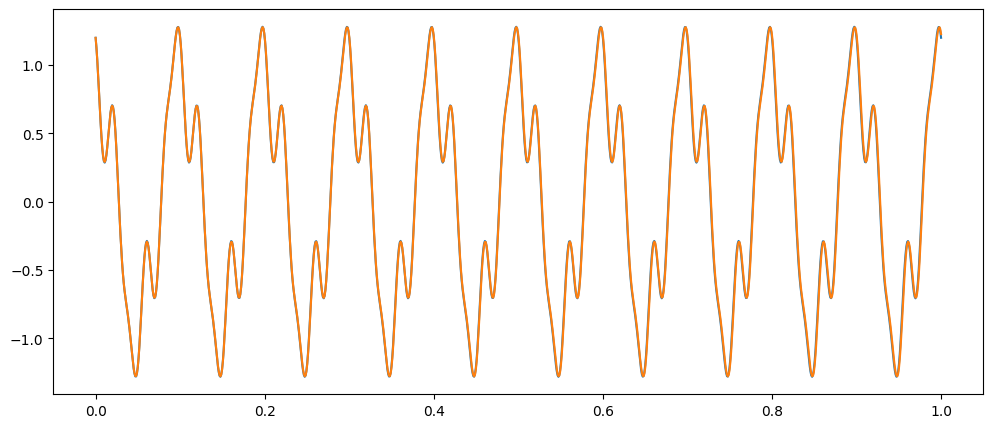

In [11]:
def signal_rec_thresholding(harm_f, harm_psd, t):
    psd_normalized = harm_psd/(harm_psd.max())
    psd_vector = np.sqrt(psd_normalized)

    #Reconstruir señal

    rec_signal = psd_vector[0]*np.cos(2*np.pi*harm_f[0]*t) - psd_vector[1]*np.sin(2*np.pi*harm_f[1]*t) + psd_vector[2]*np.cos(2*np.pi*harm_f[2]*t)

    return rec_signal

thresholding = thresholding_third_peak(f, psd_pred)
harm_f, harm_psd = thres_filter_vector(f, np.mean(psd_pred, axis=0), thresholding)

rec_signal = signal_rec_thresholding(harm_f, harm_psd, t)
plt.figure(figsize=(12,5))
plt.plot(t, real_signal(t,wo))
plt.plot(t, rec_signal)
plt.show()

In [ ]:
def NN_evaluation(sigma, t, wo, fs, nperseg, window, nfft, fn, test_size, NN_type, epochs, N, M):
    mse_vector = np.zeros(len(sigma))
    mae_vector = np.zeros(len(sigma))
    threshold_efectivity_vector = np.zeros(len(sigma))

    for j in range(len(sigma)):

        X = matrix_data(t, wo, sigma[j], N, M)

        f, Psd_real = matrix_psd(X, fs, nperseg, window, nfft, fn, N, M)

        X_train, X_test, y_train, y_test, X_scaled, Psd_scaled, scalerX, scalerPsd= data_split_scaled(X, Psd_real, test_size)

        history1, model1 = NN_define(NN_type, X_train, y_train, epochs, N, fn)

        psd_pred_scaled = model1.predict(X_scaled)
        psd_pred = scalerPsd.inverse_transform(psd_pred_scaled)

        threshold_efectivity_vector[j] = thres_efectivity(f, psd_pred)        

        mse_per_signal = np.zeros(M)
        mae_per_signal = np.zeros(M)

        for k in range(M):
            mse_per_signal[k] = mean_squared_error(psd_pred[k], Psd_real[k])
            mae_per_signal[k] = mean_absolute_error(psd_pred[k], Psd_real[k])

        mse_vector[j] = np.mean(mse_per_signal)
        mae_vector[j] = np.mean(mae_per_signal)

    rmse_vector = np.sqrt(mse_vector)

    return mse_vector, mae_vector, rmse_vector, threshold_efectivity_vector


sigma = [0, 0.1, 0.2, 0.5, 1, 5, 10, 30]
mse_vector, mae_vector, rmse_vector, threshold_efectivity = NN_evaluation(sigma, t, wo, fs, nperseg, 'blackmanharris', nfft, fn, 0.3, 1, 20, N, M)

Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - ac

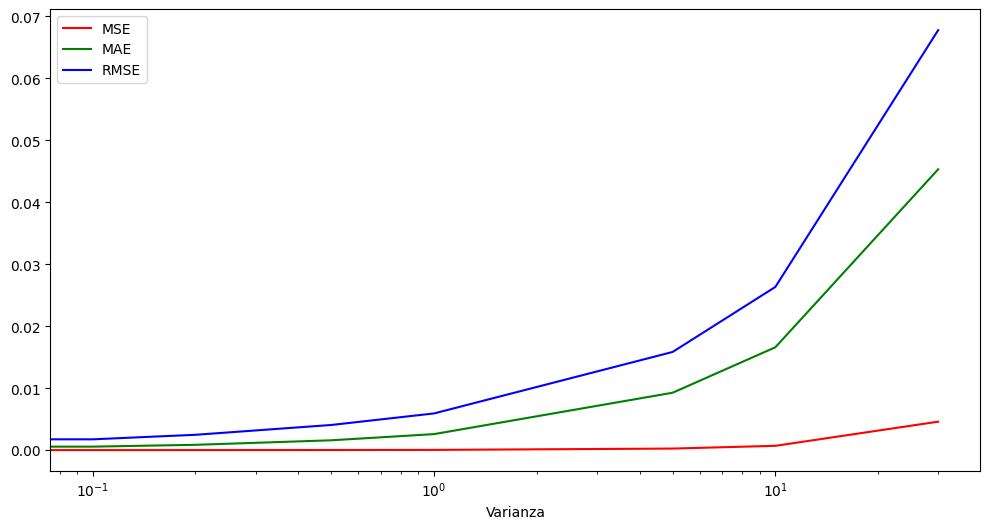

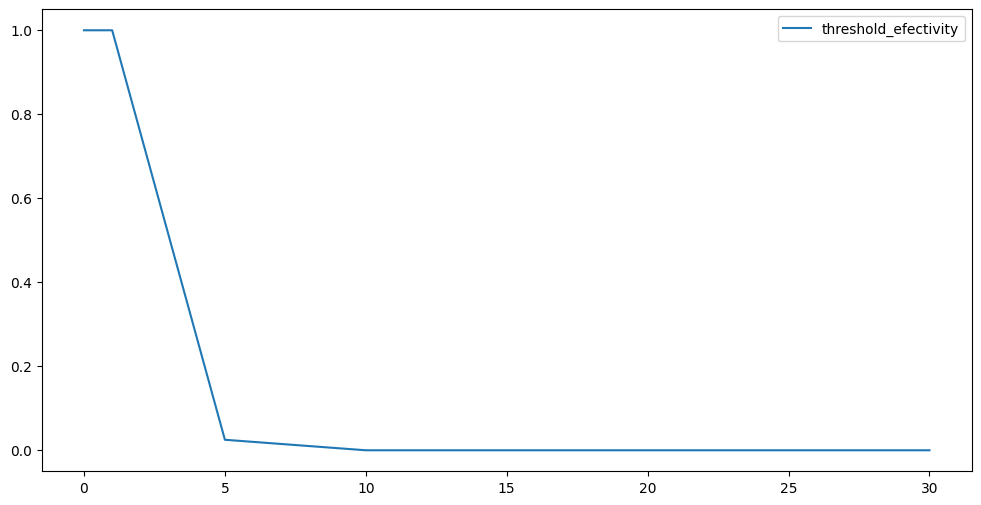

In [ ]:
plt.figure(figsize=(12,6))
plt.semilogx(sigma, mse_vector, c='r', label='MSE')
plt.semilogx(sigma, mae_vector, c='g', label='MAE')
plt.semilogx(sigma, rmse_vector, c='b', label='RMSE')
plt.xlabel('Varianza')
plt.legend()
plt.show()

plt.figure(figsize=(12,6))
plt.plot(sigma, threshold_efectivity, label='threshold_efectivity')
plt.legend()
plt.show()